# Spectral substraction
### Author: Pawel Budzynski

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile
import scipy.signal
import IPython

In [2]:
sample_rate, sound = scipy.io.wavfile.read("noise1.wav")
IPython.display.Audio("noise1.wav")

I am going to realise denoising in the time-frequency domain using spectral substraction given as 
\begin{equation}
X(\tau, \nu) = Y(\tau, \nu) \left( 1 - \frac{\lambda^2 |S_{n}(\nu)|^2}{|Y(\tau, \nu)|^2} \right)^{+},
\end{equation}
where

* $Y(\tau, \nu)$ is STFT of the noised signal, indexed by $\tau$ time index and $\nu$ frequency index.
* $\lambda$ denoising parameter.
* $S_{n}(\nu)$ power spectrum density of the noise, in this example approximated using Welch method.
* $X(\tau, \nu)$ STFT of the denoised signal. 
* $(x)^{+} = max(0, x)$.

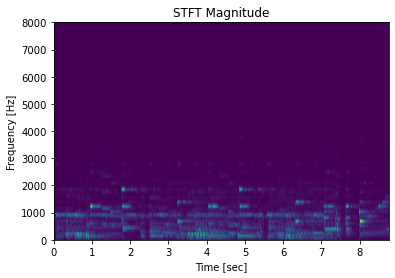

In [3]:
sample_rate, sound = scipy.io.wavfile.read("music.wav")

def plot_stft(signal: np.ndarray, sample_rate: int):
    """Plot STFT of a signal as a heatmap."""
    f, t, Zxx = scipy.signal.stft(signal, sample_rate)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
plot_stft(sound, sample_rate)

In [4]:
def snr_to_n_var(
    snr: float, 
    signal: np.ndarray,
) -> float:
    """Compute noise variance for requested SNR."""
    N = np.size(signal)
    return np.sqrt(np.sum(signal**2) / (10**(snr / 10) * N))

In [5]:
def add_noise(
    signal: np.ndarray, 
    SNR: float,
) -> np.ndarray:
    """Add noise to original signal to generate a signal with requested SNR."""
    sigma = snr_to_n_var(SNR, signal)
    noise = np.random.normal(loc=0, scale=sigma, size=signal.shape)
    return signal + noise, noise

In [6]:
sound_noise, noise = add_noise(sound, -10)
IPython.display.Audio(data=sound_noise, rate=sample_rate)

In [7]:
f, t, Zxx = scipy.signal.stft(sound_noise, sample_rate, nperseg=1000)
fx, S_n = scipy.signal.welch(noise, scaling='density', fs=sample_rate, nperseg=1000)

print(f"STFT freqency range: ({np.min(f)}, {np.max(f)}), n_points: {f.shape}")
print(f"Welch frequency range: ({np.min(fx)}, {np.max(fx)}), n_points: {fx.shape}")

STFT freqency range: (0.0, 8000.0), n_points: (501,)
Welch frequency range: (0.0, 8000.0), n_points: (501,)


Having that we will repeat $S_n$ values to match size of $Z_{xx}$ matrix representing $Y(\tau, \nu)$.

In [8]:
# Reshape S_n. 
S_n = S_n.reshape((S_n.size, 1))
# Set lambda parameter.
_lambd = 0.5
# Compute the multiplication term.
vals = (1 - ((_lambd**2) * np.abs(S_n)**2)/np.abs(Zxx)**2)
# Apply the "+" function that takes max(0, value).
vals[vals < 0] = 0
# Apply the spectral substraction.
Xxx = Zxx * vals

<ipython-input-8-725ec1bef5f6>:6: RuntimeWarning: divide by zero encountered in true_divide
  vals = (1 - ((_lambd**2) * np.abs(S_n)**2)/np.abs(Zxx)**2)


In [9]:
# Apply the inverse STFT of the computed signal to get denoised sound.
_, sound_denoised = scipy.signal.istft(Xxx, sample_rate)
# Save and play the sound.
# scipy.io.wavfile.write("music_denoised.wav", sample_rate, sound_denoised.astype(np.int16))

print("Listen to denoised recording.")
IPython.display.Audio(data=sound_denoised, rate=sample_rate)

Listen to denoised recording.


In [10]:
print("Compare it with noised version.")
IPython.display.Audio(data=sound_noise, rate=sample_rate)

Compare it with noised version.


## Adding noise from files and experiment with parameters

Having the denoising implementation done it is a time to experiment a bit with parameters and try to use noises from files to generate noised version of the signal.

In [11]:
# Load the music from file.
sample_rate, music = scipy.io.wavfile.read("music.wav")
# Load the noises from files.
noise_sr_1, noise_1 = scipy.io.wavfile.read("noise1.wav")
noise_sr_2, noise_2 = scipy.io.wavfile.read("noise2.wav")
noise_sr_3, noise_3 = scipy.io.wavfile.read("noise3.wav")

In [12]:
def normalize_signal(
    signal: np.ndarray) -> np.ndarray:
    return signal.astype(np.float64) / 2**15

music = normalize_signal(music)
noise_1 = normalize_signal(noise_1)
noise_2 = normalize_signal(noise_2)
noise_3 = normalize_signal(noise_3)

Check the properties of each of the sounds.

In [13]:
print(f"Music  :: sr: {sample_rate}, N: {sound.shape}, mean: {np.mean(sound)}")
print(f"Noise1 :: sr: {noise_sr_1}, N: {noise_1.shape}, mean: {np.mean(noise_1)}")
print(f"Noise2 :: sr: {noise_sr_2}, N: {noise_2.shape}, mean: {np.mean(noise_2)}")
print(f"Noise3 :: sr: {noise_sr_3}, N: {noise_3.shape}, mean: {np.mean(noise_3)}")

Music  :: sr: 16000, N: (140001,), mean: -0.9716502024985536
Noise1 :: sr: 16000, N: (140001,), mean: -7.056224012462412e-05
Noise2 :: sr: 16000, N: (140001,), mean: 0.015995583639246327
Noise3 :: sr: 16000, N: (140001,), mean: 0.010495903248431039


The music and the noises have the same shape thus can be added directly. Although noise 2 and 3 are not white noises their mean value remains close to $0$ thus I am going to assume that $\mu = 0$ and use this fact to compute scaling factor of the noise to obtain desired SNR. 

In [14]:
def snr(
    x: np.ndarray, 
    y: np.ndarray,
) -> float:
    """Compute Signal to noise ratio given original signal 
    and signal with a noise added.
    
    Parameters:
        x: original signal. 
        y: noised signal.
    """
    return 10 * np.log10(np.sum(x**2) / np.sum((x - y)**2))

In [15]:
print("SNR nosie 1:", snr(music, music + noise_1))
print("SNR nosie 2:", snr(music, music + noise_2))
print("SNR nosie 3:", snr(music, music + noise_3))

SNR nosie 1: 0.5792015206832329
SNR nosie 2: -0.027626963445336522
SNR nosie 3: 0.6154077796228986


Since SNR ratio for the noices are pretty low I am going to prepare a function to scale them to obtain requested SNR ratio. The scaling will be realised by multiplying the noise by standard deviation computed for requested SNR ratio, the function was defined in the previous exercise.

In [16]:
def snr_to_n_var(
    snr: float, 
    signal: np.ndarray,
) -> float:
    """Compute noise variance for requested SNR."""
    N = np.size(signal)
    return np.sqrt(np.sum(signal**2) / (10**(snr / 10) * N))

def scale_noise(
    noise: np.ndarray,
    SNR: float,
    signal: np.ndarray,
) -> np.ndarray:
    """Scale noise to obtain desired SNR after adding it to the signal."""
    sigma = snr_to_n_var(SNR, signal)
    return (noise / np.std(noise)) * sigma

Check if scaling works correctly. 

In [17]:
noise_20 = scale_noise(noise_1, 20, music)
print("SNR (20): ", snr(music, music + noise_20))
noise_5 = scale_noise(noise_2, 5, music)
print("SNR (5):", snr(music, music + noise_5))
noise_0 = scale_noise(noise_3, 0, music)
print("SNR (0):", snr(music, music + noise_0))

SNR (20):  19.999999529877098
SNR (5): 4.978941059278041
SNR (0): -0.010501513622602671


Having the entire denoising procedure described above I am definind a complete function here to perform substrac substraction easily.

In [18]:
def denoise_spectral_subs(
    signal: np.ndarray,
    noise: np.ndarray,
    sample_rate: int,
    _lambda: float,
    nperseg: int = 1000,
) -> np.ndarray:
    """Perform spectral substraction on a noised signal given 
    the noised signal and noise.
    
    Parameters:
        signal: noised signal to denoise. 
        noise: noise added to the noised signal. 
        sample_rate: sample rate of the audio recording. 
        _lambda: lambda parameter for the spectral substraction. 
        nperseg: segment size used in STFT and Welch. 
    """
    
    # Get STFT of the noised signal.
    _, _, Yxx = scipy.signal.stft(signal, sample_rate, nperseg=nperseg)
    # Get power spectrum density of the nosie.
    _, S_n = scipy.signal.welch(
        noise, scaling='density', fs=sample_rate, nperseg=nperseg)
    # Resize the array to be able to use it in computation easily.
    S_n = S_n.reshape((S_n.size, 1))
    
    # Compute the multiplication term.
    vals = (1 - ((_lambda**2) * np.abs(S_n)**2)/np.abs(Yxx)**2)
    # Apply the "+" function that takes max(0, value).
    vals[vals < 0] = 0
    # Apply the spectral substraction.
    Xxx = Yxx * vals
    
    _, sound_denoised = scipy.signal.istft(Xxx, sample_rate)
    return sound_denoised

In [19]:
def denoising(
    signal: np.ndarray,
    noise: np.ndarray,
    sample_rate: int,
    SNR: float,
    _lambda: float,
    nperseg: int = 200,
):
    """Perform denoising by spectral substraction on a noised signal. 
    Adds given noise to the signal. Before adding noise is scaled to 
    obtain requested SNR after addition.
    Display noised and denoised audios for comparison. 
    
    Paramters:
        signal: original signal without a noise.
        noise: noise to add to the signal. 
        sample_rate: sample rate of the audio signals.
        SNR: requested signal to noise ratio. Noise will be
             scaled with respect to this value. 
        _lambda: lambda parameter used in spectral substraction.
        
    Returns:
        Original signal and noised signal. 
    """
    # Scale the noise to get desired SNR.
    noise_scaled = scale_noise(noise, SNR, signal)
    # Add noise to the sound.
    signal_noise = signal + noise_scaled
    
    print("Generated noised signal with SNR", snr(signal, signal_noise))
    
    # Denoise the signal using spectral substraction.
    denoised = denoise_spectral_subs(
        signal_noise, noise_scaled, sample_rate, _lambda, nperseg)
    
    display_signal_noise = IPython.display.Audio(
        data=(signal_noise*2**15).astype(np.int16), rate=sample_rate,
    )
    
    display_signal_denoise = IPython.display.Audio(
        data=(denoised*2**15).astype(np.int16), rate=sample_rate,
    )
    
    print("Signal with noise:")
    IPython.display.display(display_signal_noise)
    print("Signal denoised:")
    IPython.display.display(display_signal_denoise)
    
    return signal, signal_noise

Generated noised signal with SNR 9.989498486377396
Signal with noise:


<ipython-input-18-ce52eb69f335>:28: RuntimeWarning: divide by zero encountered in true_divide
  vals = (1 - ((_lambda**2) * np.abs(S_n)**2)/np.abs(Yxx)**2)


Signal denoised:


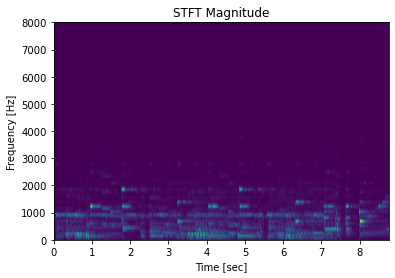

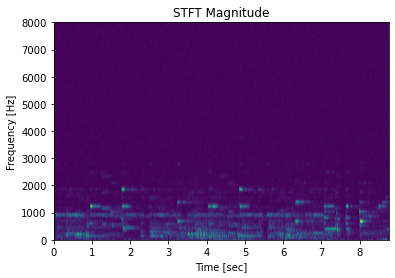

In [20]:
signal, signal_noise = denoising(
    signal=music,
    noise=noise_3,
    sample_rate=sample_rate,
    SNR=10,
    _lambda=1e4,
    nperseg=1000,
)

plot_stft(signal, sample_rate)
plot_stft(signal_noise, sample_rate)

## Conclusions

- Denoising using spectral substraction was implemented.
- Numerous variants of noised sound with noises of different colours and various SNR ratios were used in experiments.
- Depending on the values and representation of the sound data different parameters should be used. For example, after normalizing values in audio representation by dividing them by $2^{15}$ $\lambda$ parameter has to be pretty big of magnitute $10^3$ or $10^4$ while without normalization rather small values worked well. 
- Bigger values of $\lambda$ corresponds to more aggresive denoising that results in losing information from the signal. If too big value was chosen one can no longer hear the music. 
- When $\lambda$ was chosen properly denoising gave pretty good results and removed noise from the noised data. 
- Even though it produces nice results this method of denoising requires a knowledge of noise applied to the signal which makes it harded to use in practice.